# Fully Connected MNIST
This is to get a feel for building classifiers in TF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)

# auto reloading of modules
%load_ext autoreload
%autoreload 2

In [2]:
# Settings
batch_size = 1000 
epochs = 10 # number of epochs to train for
learning_rate = .1
momentum = .9
print_every = 25 # print info about training at iterations
test_every = 50 # number of iterations to go between doing 1 epoch of testing

reg = 0.01 # regularization strength

num_train = 60000 # 60000 max
num_test = 5000 # 10000 max

layer_sizes = [512,256] # these are the sizes of the hidden layers

checkpoint_file = 'models/MNIST_FC.ckpt'

In [3]:
# these are updates/modifications/ utilites based on settings, do not change

# fixed seed for consistancy
np.random.seed(0)

# set up number of batches, make sure its a valid number
num_batches_train = num_train/batch_size
num_batches_test = num_test/batch_size
assert num_train%batch_size == 0, 'The number of training samples must be divisible by the batch size'
assert num_test%batch_size == 0, 'The number of test samples must be divisible by the batch size'

# MNIST is 28x28x1 images
img_shape = (28,28,1)
img_size = 28*28*1

# modify the layer_sizes to account for input and output
layer_sizes.insert(0, img_size) # input layer
layer_sizes.append(10) # output later

## Using code from 3_mnist_from_scratch tutorial to deal with downloads and working with MNIST data

Took the code and made a simple module to make everything cleaner

In [4]:
import getMNIST
fNames = getMNIST.downloadMNIST()

train_data = getMNIST.extract_data(fNames[0],num_train)
test_data = getMNIST.extract_data(fNames[2],num_test)

train_labels = getMNIST.extract_labels(fNames[1], num_train)
test_labels = getMNIST.extract_labels(fNames[3], num_test)

('Already downloaded', 'train-images-idx3-ubyte.gz')
('Already downloaded', 'train-labels-idx1-ubyte.gz')
('Already downloaded', 't10k-images-idx3-ubyte.gz')
('Already downloaded', 't10k-labels-idx1-ubyte.gz')
('Extracting', '/tmp/mnist-data/train-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist-data/t10k-images-idx3-ubyte.gz')
('Extracting', '/tmp/mnist-data/train-labels-idx1-ubyte.gz')
('Extracting', '/tmp/mnist-data/t10k-labels-idx1-ubyte.gz')


## Making the data useful to our model
We have the images stored as [num_train,28,28,1] tensors, for fully connected we want them to be [num_train, 28*28*1] tensors for the fully connected net. In FC, the spatial relationship does not need to be preserved

In [5]:
train_data = train_data.reshape(num_train, img_size)
test_data = test_data.reshape(num_test, img_size)

## Building the model

In [6]:
# Set up inputs and outputs
X = tf.placeholder(tf.float32, shape = [batch_size,img_size])
Y = tf.placeholder(tf.float32, shape = [batch_size,10]) # 10 labels

In [7]:
# setup model weights
weights = {}
bias = {}
for layer in range(1,len(layer_sizes)):
    layer_name = 'FC'+str(layer)
    weights[layer_name] = tf.Variable(tf.random_normal([layer_sizes[layer-1],layer_sizes[layer]])*.01,name=layer_name)
    bias[layer_name] = tf.Variable(tf.constant(0.1, shape=[layer_sizes[layer]]))
print weights
print bias

{'FC1': <tf.Variable 'FC1:0' shape=(784, 512) dtype=float32_ref>, 'FC2': <tf.Variable 'FC2:0' shape=(512, 256) dtype=float32_ref>, 'FC3': <tf.Variable 'FC3:0' shape=(256, 10) dtype=float32_ref>}
{'FC1': <tf.Variable 'Variable:0' shape=(512,) dtype=float32_ref>, 'FC2': <tf.Variable 'Variable_1:0' shape=(256,) dtype=float32_ref>, 'FC3': <tf.Variable 'Variable_2:0' shape=(10,) dtype=float32_ref>}


In [8]:
# build the model

# dicts to store intermediate values
matMuls = {}
relu = {}
previous_layer = X

for layer in range(1,len(layer_sizes)):
    layer_name = 'FC' + str(layer)    
    matMuls[layer_name] = tf.matmul(previous_layer,weights[layer_name]) + bias[layer_name]
    #apply relu
    relu[layer_name] = tf.nn.relu(matMuls[layer_name])
    previous_layer = relu[layer_name]
    
    # print the shapes
    print('{} * {} = {}'.format(previous_layer.shape,weights[layer_name].shape, matMuls[layer_name].shape))

    
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits = matMuls[layer_name]))

# regularization loss
for ii in weights:
    loss += reg * tf.nn.l2_loss(weights[ii])

predictions = tf.nn.softmax(logits = matMuls[layer_name])

num_correct = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions,1), tf.argmax(Y,1)),tf.float32))



(1000, 512) * (784, 512) = (1000, 512)
(1000, 256) * (512, 256) = (1000, 256)
(1000, 10) * (256, 10) = (1000, 10)


In [9]:
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum).minimize(loss)
init = tf.global_variables_initializer()

In [10]:
# loss history
losses_train = np.array([])
losses_test = np.array([])
# accuracy history
acc_train = np.array([])
acc_test = np.array([])

saver = tf.train.Saver()

iteration = -1 # counter
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in xrange(epochs):        
        for batch in xrange(num_batches_train):
            iteration += 1
            
            batch_start = batch*batch_size
            batch_end = batch_start + batch_size
            
            # We want different info based on the iteration. 
            # We dont actually need to compute everything on every iteration            
            if iteration % print_every == 0:
                solveFor = [optimizer, loss, predictions, num_correct]
            else:
                solveFor = [optimizer, loss]
            
            # run it
            out = sess.run(solveFor,
                           feed_dict={X:train_data[batch_start:batch_end,:],
                                      Y:train_labels[batch_start:batch_end]})
            
            if iteration % print_every == 0:
                _, l, pred, correct = out
                acc_train = np.append(acc_train, correct.astype(np.float32)/float(batch_size))
            else:
                _, l = out
                
            losses_train = np.append(losses_train,l)
            
            if iteration % print_every == 0:
                print('Iteration: {}/{}, batch {} on epoch {}, \tLoss: {:.2e}, Train Acc: {:.3f}'.format(iteration, 
                                                                                            epochs*num_batches_train,
                                                                                            batch, 
                                                                                            epoch, 
                                                                                            l, 
                                                                                            acc_train[-1]))
            
            if iteration % test_every == 0:
                l_test = 0
                correct_test = 0
                for test_it in xrange(num_batches_test):
                    batch_start = test_it*batch_size
                    batch_end = batch_start + batch_size
                    l, correct = sess.run([loss,num_correct],
                                         feed_dict={X:test_data[batch_start:batch_end,:],
                                                    Y:test_labels[batch_start:batch_end]})
                    correct_test += correct
                    l_test += l
                losses_train = np.append(losses_train,l_test.astype(np.float32)/float(num_batches_test))
                acc_test = np.append(acc_test, correct_test.astype(np.float32)/float(num_test))
                print('Testing Loss: {:.2e}\tTesting Accuracy: {:.3f}\n'.format(l_test, acc_test[-1]))
    save_path = saver.save(sess, checkpoint_file)
    print("Model saved in file: %s" % save_path)

Iteration: 0/600, batch 0 on epoch 0, 	Loss: 2.57e+00, Train Acc: 0.100
Testing Loss: 1.28e+01	Testing Accuracy: 0.106

Iteration: 25/600, batch 25 on epoch 0, 	Loss: 2.27e+00, Train Acc: 0.422
Iteration: 50/600, batch 50 on epoch 0, 	Loss: 1.68e+00, Train Acc: 0.510
Testing Loss: 8.17e+00	Testing Accuracy: 0.496

Iteration: 75/600, batch 15 on epoch 1, 	Loss: 1.02e+00, Train Acc: 0.818
Iteration: 100/600, batch 40 on epoch 1, 	Loss: 7.41e-01, Train Acc: 0.887
Testing Loss: 4.13e+00	Testing Accuracy: 0.863

Iteration: 125/600, batch 5 on epoch 2, 	Loss: 6.77e-01, Train Acc: 0.904
Iteration: 150/600, batch 30 on epoch 2, 	Loss: 6.56e-01, Train Acc: 0.895
Testing Loss: 3.41e+00	Testing Accuracy: 0.882

Iteration: 175/600, batch 55 on epoch 2, 	Loss: 5.41e-01, Train Acc: 0.923
Iteration: 200/600, batch 20 on epoch 3, 	Loss: 6.06e-01, Train Acc: 0.918
Testing Loss: 3.10e+00	Testing Accuracy: 0.898

Iteration: 225/600, batch 45 on epoch 3, 	Loss: 5.93e-01, Train Acc: 0.911
Iteration: 250/60

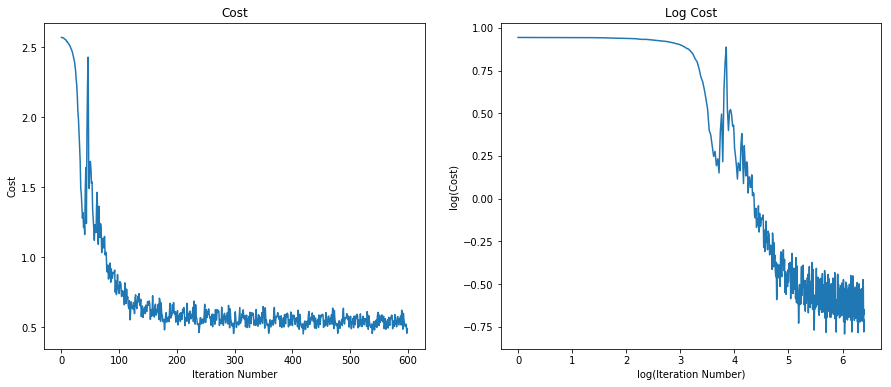

In [11]:
# Visualize the cost and log cost from training
plt.rcParams['figure.figsize'] = (15,6)

plt.subplot(121)
plt.plot(np.linspace(0,iteration,losses_train.shape[0]),losses_train,label='Training Loss')
plt.plot(np.linspace(0,iteration,losses_test.shape[0]),losses_test,label='Testing Loss')

plt.title('Cost')
plt.xlabel('Iteration Number')
plt.ylabel('Cost')

plt.subplot(122)
plt.plot(np.log(np.linspace(1,iteration,losses_train.shape[0])),np.log(losses_train),label='Training Loss')
plt.plot(np.log(np.linspace(1,iteration,losses_test.shape[0])),np.log(losses_test),label='Testing Loss')
plt.title('Log Cost')
plt.xlabel('log(Iteration Number)')
plt.ylabel('log(Cost)')

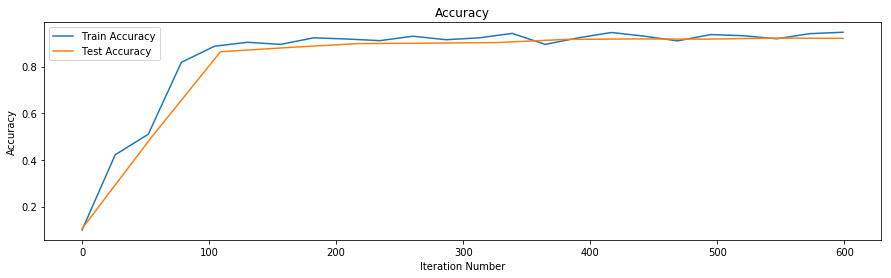

In [12]:
# See how the accuracy plays out between the test and training set
plt.rcParams['figure.figsize'] = (15,4)

plt.figure()
plt.plot(np.linspace(0,iteration,acc_train.shape[0]),acc_train,label = 'Train Accuracy')
plt.plot(np.linspace(0,iteration,acc_test.shape[0]),acc_test,label = 'Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.legend()


## Visualizing the model outputs
Want to see how the model did, specifically what is was confused on

In [13]:
# Generate predictions for the test and train set
saver = tf.train.Saver()

pred_train = np.zeros((num_train,10))
pred_test = np.zeros((num_test,10))


with tf.Session() as sess:
    # load the model from before
    saver.restore(sess, checkpoint_file)
    print('Finished loading the model')
    
    # batch over the entire training set and record predictions
    for it in xrange(num_batches_train):
        batch_start = it*batch_size
        batch_end = batch_start + batch_size
        pred_train[batch_start:batch_end,:] = sess.run(predictions,
                                                     feed_dict={X:train_data[batch_start:batch_end,:],
                                                                Y:train_labels[batch_start:batch_end]})
    print('Finished predictions for training data')
    
    # batch over the entire testing set and record predictions
    for it in xrange(num_batches_test):
        batch_start = it*batch_size
        batch_end = batch_start + batch_size
        pred_test[batch_start:batch_end,:] = sess.run(predictions,
                                                     feed_dict={X:test_data[batch_start:batch_end,:],
                                                                Y:test_labels[batch_start:batch_end]})
    print('Finished predictions for testing data')
print('Done!')

INFO:tensorflow:Restoring parameters from models/MNIST_FC.ckpt
Finished loading the model
Finished predictions for training data
Finished predictions for testing data
Done!


In [14]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""    
    actual = np.argmax(labels,1)
    pred = np.argmax(predictions,1)
    correct = np.sum(pred == actual)
    total = pred.shape[0]
    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    for ii in xrange(predictions.shape[0]):        
        confusions[pred[ii], actual[ii]] += 1
    
    return error, confusions

Train error: 6.7%


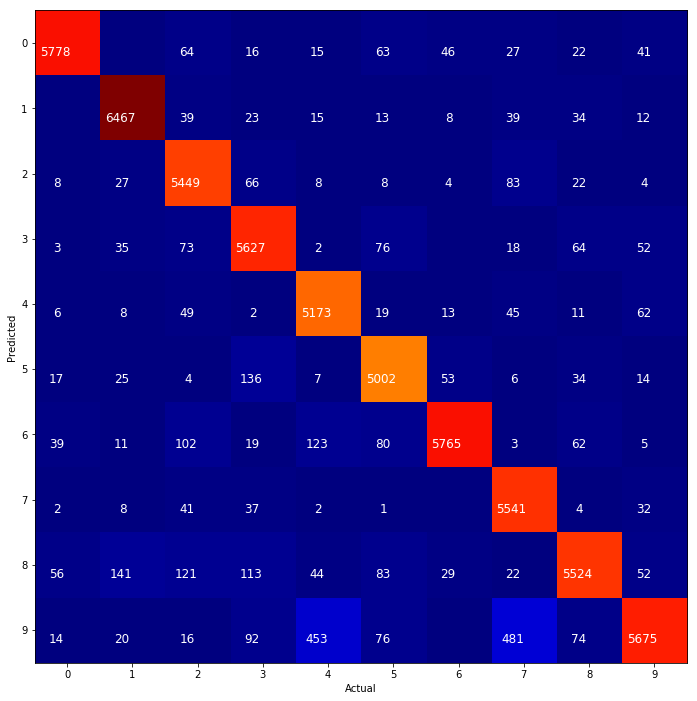

In [15]:
# Make confusion plot of the training set
plt.rcParams['figure.figsize'] = (20, 12)

error_train, confusions_train = error_rate(pred_train, train_labels)
print('Train error: %.1f%%' % error_train)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(confusions_train, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions_train):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='white')

Test error: 8.5%


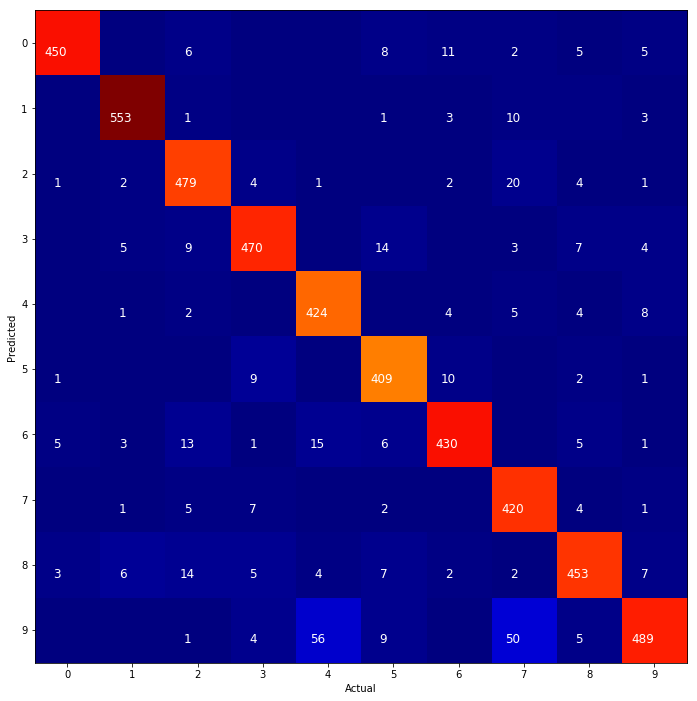

In [16]:
# Make confusion plot of the test set
plt.rcParams['figure.figsize'] = (20, 12)

error_test, confusions_test = error_rate(pred_test, test_labels)
print('Test error: %.1f%%' % error_test)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.imshow(confusions_train, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions_test):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='white')